# A new approach for the dynamics of ultra-high-frequency data: The model with uncertainty zones - simulation

## Librairies importation

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## Simulation of observed price

In [2]:
# Black-Scholes prices

def x_t(x0, sigma, mu, t, n, m):
    dt = t/n
    dW = np.zeros((m, n+1))
    dW[:,1:] = np.random.normal(0, np.sqrt(dt), (m,n))
    W = np.cumsum(dW, axis=1)

    t = np.linspace(0, t, n+1)
    x = np.zeros((m, n+1))
    x[:,0] = x0
    x[:,1:] = x0*np.exp((mu - 0.5*sigma**2)*t[1:] + sigma*W[:,1:])

    return x

# Algorithm with uncertainty zones
def algo_uncertainty(xt, alpha, eta):
    n = len(xt) - 1 # number of time steps

    thos = [] # list of exit times
    thos.append(0) # initial time

    d_k = lambda k: (k + 0.5 -eta)*alpha #lower bound of the k-th uncertainty zone
    u_k = lambda k: (k + 0.5 + eta)*alpha #upper bound of the k-th uncertainty zone

    #x_rounded = lambda x: int(x/alpha)*alpha if x/alpha - int(x/alpha) < 0.5 else (int(x/alpha) + 1)*alpha #round x to the nearest multiple of alpha 
    x_rounded = lambda x : np.round(x / alpha) * alpha
    #x_rounded = lambda x: int(x/alpha)*alpha #round x to the nearest multiple of alpha

    k0 = x_rounded(xt[0])/alpha # initial zone
    t = 0
    while xt[t]>= d_k(k0-1) and xt[t]<= u_k(k0) and t < n:
        t += 1
    thos.append(t) # tho_1

    while t < n:
        ki = x_rounded(xt[t])/alpha # current zone
        while xt[t]>= d_k(ki-1) and xt[t]<= u_k(ki) and t < n:
            t += 1
        thos.append(t)
    
    return thos

def algo_uncertainty_matrix(xt_matrix, alpha, eta):
    num_observations, num_time_steps = xt_matrix.shape
    thos_matrix = np.zeros((num_observations, num_time_steps), dtype=int)

    for i in range(num_observations):
        thos = algo_uncertainty(xt_matrix[i], alpha, eta)
        thos_matrix[i, :len(thos)] = thos

    return thos_matrix
 

In [3]:
# parameters
t = 1 # time horizon
m = 1 # number of paths

# bs params
x0 = 100
sigma = 0.2
mu = 0

alpha = 0.5 # tick size
eta = 0.6 # risk aversion
acc = 0.1 # simulation accuracy

n =  int(8*3600*(1/acc)) # number of time steps, trading day of 8 hours

print(n)

288000


1072


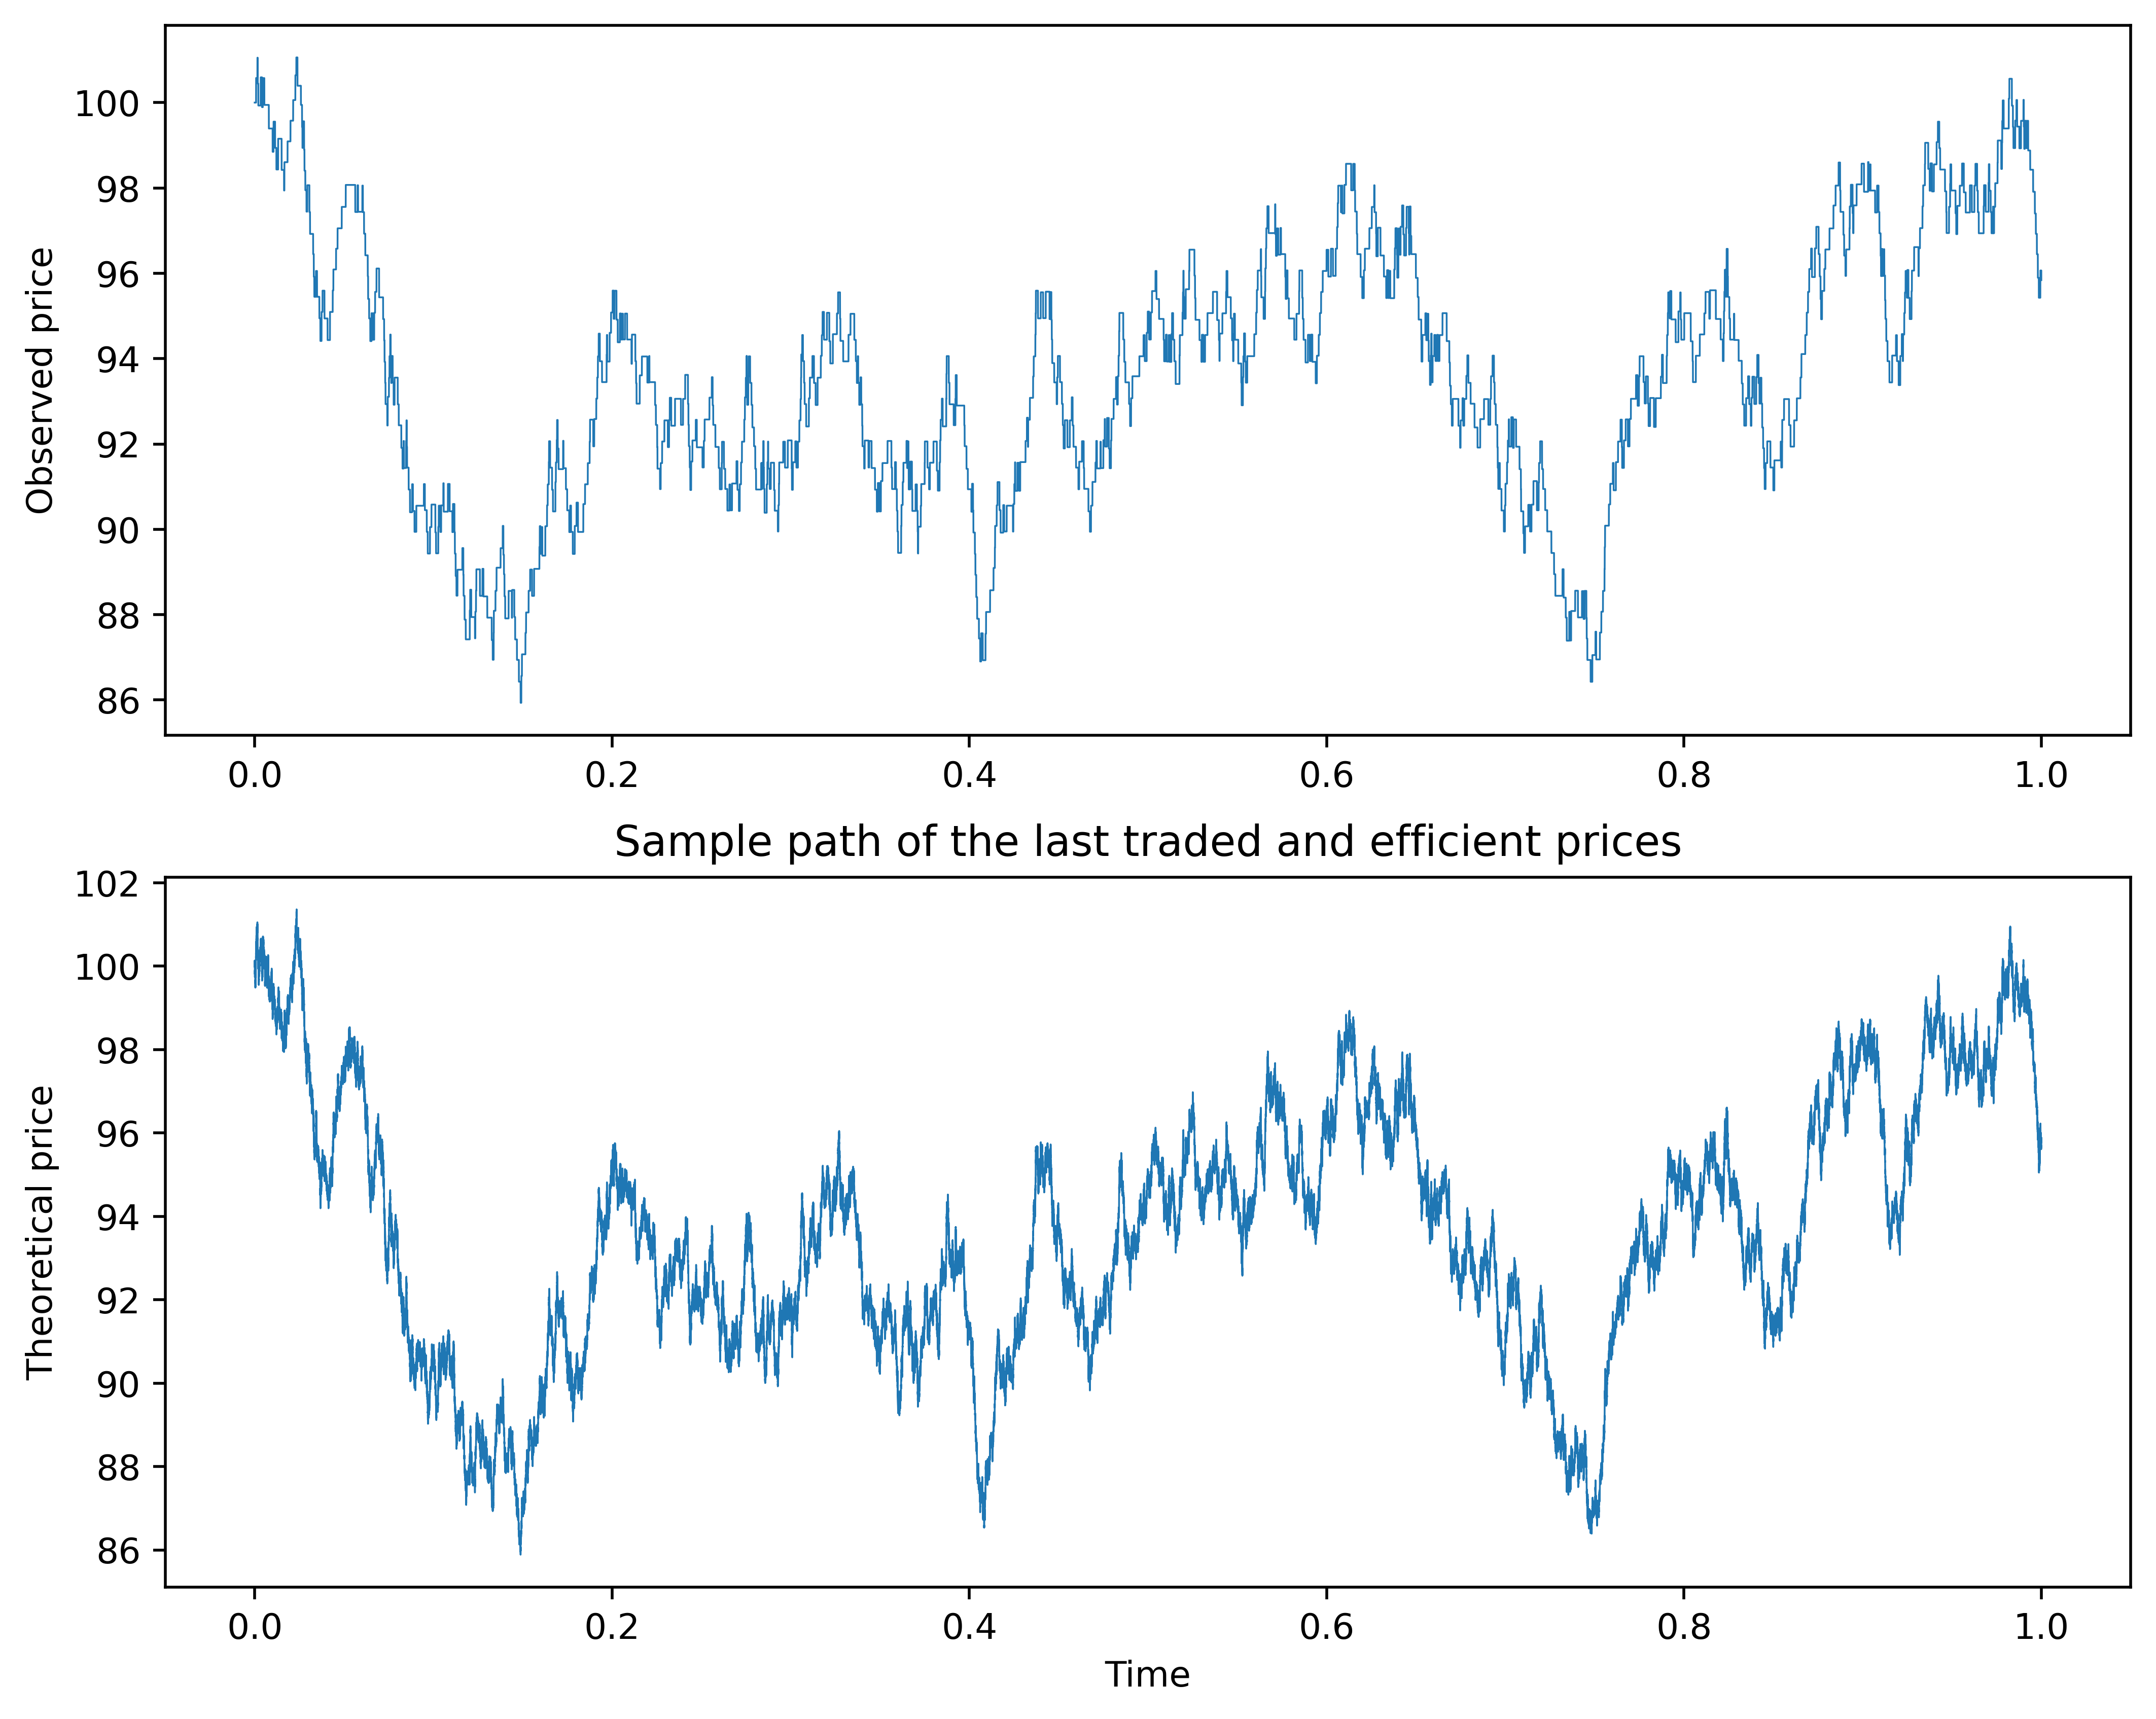

In [4]:
xt = x_t(x0, sigma, mu, t, n, m)[0]
thos = algo_uncertainty(xt, alpha, eta)
print( len(thos))
times = np.linspace(0, t, n+1)

# observed prices and uncertainty zones
observed_prices = np.zeros_like(times)

# Fill observed prices array
for i in range(len(thos) - 1):
    observed_prices[thos[i]:thos[i+1]] = xt[thos[i]]
# For the last interval
observed_prices[thos[-1]:] = xt[thos[-1]]

plt.figure(figsize=(10,8), dpi=500)

plt.subplot(2,1,1)
plt.plot(times, observed_prices, linewidth=.5)
plt.ylabel('Observed price')

plt.subplot(2,1,2)
plt.plot(times, xt, linewidth=.5)
plt.ylabel('Theoretical price')
plt.xlabel('Time')

plt.title('Sample path of the last traded and efficient prices')
plt.show()


## Simulation of the volatility estimator

### MC Estimators

In [5]:
def realized_volatility(S):
    '''
        S: (m x n+1) matrix of stock prices
        returns: (m,) vector of realized volatilities
    '''
    return np.sum(np.diff(S)**2)

def two_time_scales_volatility(S, noise, sigma, T, n):
    '''
        S: (m x n+1) matrix of stock prices
        noise: standard deviation of the noise
        sigma: volatility
        T: final time
        n: number of time steps

        returns: (m,) vector of two time scales volatilities
    '''

    S = np.log(S) + noise * np.random.randn(*S.shape)

    # Optimal frequency for sparse sampling and number of sparse grids (K)
    n_sparse = ((sigma**4 * T**2) / (6 * noise**4))**(1/3)
    K = max(int(np.floor((2**(1/3) * n**(2/3)) / n_sparse)), 1)

    # Effective number of steps in each sparse grid
    n_bar = max(1, int(n / K))
    
    # Calculate realized volatility for each sparse sample
    sparse_volatilities = np.zeros((K))
    for i in range(K):
        # Sparse sampling: taking every K-th point starting from i
        S_sparse = S[i::K]
        sparse_volatilities[i] = realized_volatility(S_sparse)

    # Calculate the average of sparse volatilities
    avg_sparse_vol = np.mean(sparse_volatilities, axis=0)

    # Calculate realized volatility over the entire data set
    S_all = realized_volatility(S)

    # Compute the two time scales volatility
    result = avg_sparse_vol - ((n_bar-1) / n) * S_all

    return result

def two_time_scales_volatility_matrix(S, noise, sigma, T, n):
    m, _ = S.shape
    result = np.zeros((m))

    for i in range(m):
        result[i] = two_time_scales_volatility(S[i], noise, sigma, T, n)

    return result

In [6]:
# realised volatility estimation

def est_realised_volatility(xt, thos, t):
    rv = 0
    i = 0

    while (thos[i+1]/n)< t:
        rv += ((xt[thos[i+1]] - xt[thos[i]])/(xt[thos[i]]))**2 
        i += 1
    return rv

sigma_est = np.sqrt(est_realised_volatility(xt, thos, 1))
print("Estimated volatility: ", sigma_est)
print("Error between the estimated and real volatilities: ", (np.abs(sigma_est - sigma)/sigma)*100, "%")

Estimated volatility:  0.19793247801330446
Error between the estimated and real volatilities:  1.0337609933477738 %


In [7]:
thos2 = algo_uncertainty(xt, 0.05, 0.05)
sigma_est2 = np.sqrt(est_realised_volatility(xt, thos2, 1))
print("Estimated volatility: ", sigma_est2)
print("Error between the estimated and real volatilities: ", (np.abs(sigma_est2 - sigma)/sigma)*100, "%")

Estimated volatility:  0.19962993867622206
Error between the estimated and real volatilities:  0.18503066188897688 %


In [8]:
xtfiltr = observed_prices[::int(1/acc)]

sigmats = np.sqrt(two_time_scales_volatility(xtfiltr, 0.1, sigma, 1, len(xtfiltr)-1))

print("Two time scales volatility: ", sigmats)
print("Error between the two time scales and real volatilities: ", (np.abs(sigmats - sigma)/sigma)*100, "%")

Two time scales volatility:  0.22727399984430588
Error between the two time scales and real volatilities:  13.636999922152935 %


### CLT

In [9]:
m = 1000
xt_matrix = x_t(x0, sigma, mu, t, n, m)
thos_matrix = algo_uncertainty_matrix(xt_matrix, alpha, eta)

x = np.linspace(-5, 5, 100)
def gauss(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))


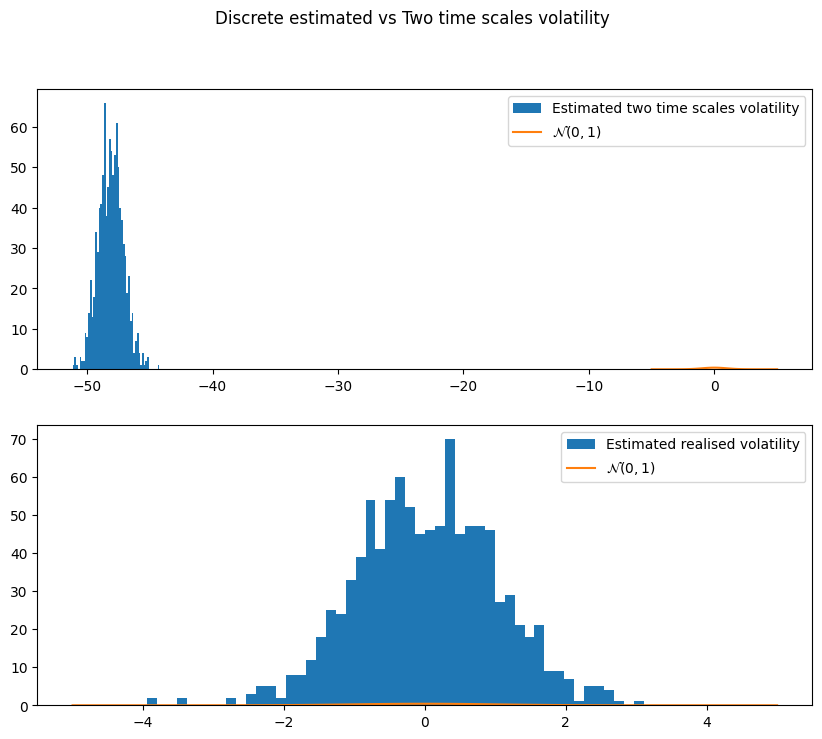

In [ ]:
observed_prices_matrix = np.zeros((m, n+1))
for i in range(m):
    for j in range(len(thos_matrix[i]) - 1):
        observed_prices_matrix[i, thos_matrix[i][j]:thos_matrix[i][j+1]] = xt_matrix[i, thos_matrix[i][j]]
    observed_prices_matrix[i, thos_matrix[i][-1]:] = xt_matrix[i, thos_matrix[i][-1]]

xmatrixfiltr = observed_prices_matrix[:, ::int(1/acc)]


# Realised volatility estimation for each path
rv = np.zeros(m)
for i in range(m):
    rv[i] = est_realised_volatility(xt_matrix[i], thos_matrix[i], 1)

estimated_sigmas = two_time_scales_volatility_matrix(xmatrixfiltr, 0.1, sigma, t, n)

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.hist((estimated_sigmas - sigma**2)/np.std(estimated_sigmas), bins=50, label='Estimated two time scales volatility')
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend()

plt.subplot(2,1,2)
plt.hist((rv - sigma**2)/np.std(rv), bins=50, label='Estimated realised volatility')
plt.plot(x, gauss(x, 0, 1), label='$\mathcal{N}(0, 1)$')
plt.legend()

plt.suptitle('Discrete estimated vs Two time scales volatility')
plt.show()
